In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
%matplotlib inline
plt.ion()
from random import randint
import time
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
ops.reset_default_graph()
print("OK")

OK


## 1峰と2峰のデータをまぜたよ

In [2]:
"""csvファイルの読み込み"""
inputdata = pd.read_csv('2mine.csv', encoding='shift_jis',dtype = 'float')
a_df = inputdata.values
#a_df = b_df[np.array(b_df[:,1141:1142]>0.5).flatten()][:]
#a_df = a_df[np.array(a_df[:,16*71+5:16*71+6]<1.40).flatten()][:]
print(np.shape(a_df))

(30000, 1147)


In [3]:
input_shape_rows   =16  #入力データの行
input_shape_columns=len(np.arange(0, 2.11,0.03))  #入力データの列
output_shape= 10        #出力の

"""入力データと出力データを分けて読み込む"""
#x_vals = np.array([x[0:816] for x in a_df])
#y_vals = np.array([x[816:821] for x in a_df])
xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in a_df])
print(ydata[0][0])

5.7564660000000005


In [4]:
"""結果を再現可能にするためのランダムシードを作成"""
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)
print("OK")

OK


In [5]:
"""正規化の定義"""
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max-col_min) 

"""データの最大値と最小値を保存"""
col_max0 = ydata.max(axis=0)
col_min0 = ydata.min(axis=0) 

"""正規化の実行"""
#x_vals0 = np.nan_to_num(normalize_cols(x_vals))   #入力の正規化は不要
ydata_0 = np.nan_to_num(normalize_cols(ydata))

"""訓練データとテストデータを8：2に分割するためのインデックスを作成"""
train_indices = np.random.choice(len(xdata), round(len(xdata)*0.8), replace=False)  #訓練データに使うindex
test_indices  = np.array(list(set(range(len(xdata))) - set(train_indices)))         #テストデータに使うindex

"""入力データを訓練とテストにわけた"""
train_xdata   = xdata[train_indices]    #入力データの訓練集合
test_xdata    = xdata[test_indices]     #入力データのテスト集合

"""出力データを訓練とテストにわけた"""
train_ydata   = ydata_0[train_indices]  #出力データの訓練集合(正規化済み)
test_ydata    = ydata_0[test_indices]   #出力データのテスト集合(正規化済み)
test_ydata_origin    = ydata[test_indices] #出力データのテスト集合(正解値)
print("OK")

OK


In [6]:
"""Convert labels into one-hot encoded vectors"""
#train_labels = mnist.train.labels
#test_labels = mnist.test.labels
print("OK")

OK


In [8]:
"""ネットワーク構造のパラメータを設定"""
batch_size          = 50                     #一回の学習に使うデータの数
learning_rate       = 0.005
evaluation_size     = 100                     #一回のテストに使うデータの数  #len(test_indices) 
image_height        = train_xdata[0].shape[0]  #行
image_width         = train_xdata[0].shape[1]  #列
target_size         = output_shape
num_channels        = 1                        # greyscale = 1 channel
conv1_features      = 16                        #1回目の畳み込みの枚数
filter_size1        = 11
conv2_features      = 20                       #2回目の畳み込みの枚数
filter_size2        = 7
max_pool_size1      = 2                        #プーリング層
max_pool_size2      = 2                        # プーリング層
fully_connected_size1 = 130                     #全結合層のノード数?
fully_connected_size2 = 80
fully_connected_size3 = 50
keep_prob = tf.placeholder(tf.float32)
print("OK")

OK


In [9]:
"""入力データのサイズの格納庫作成"""
x_input_shape = (batch_size, image_height, image_width,num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
"""出力データのサイズと格納庫作成"""
y_target = tf.placeholder(tf.float32, shape=(batch_size,output_shape))   


"""入力データのサイズの格納庫作成"""
test_x_input_shape = (evaluation_size, image_height, image_width,num_channels)
test_x_input = tf.placeholder(tf.float32, shape=test_x_input_shape)
"""出力データのサイズと格納庫作成"""
test_y_target = tf.placeholder(tf.float32, shape=(evaluation_size, output_shape))  


"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
eval_x_input_shape = (len(test_xdata), image_height, image_width,num_channels)
eval_x_input = tf.placeholder(tf.float32, shape=eval_x_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
eval_y_target = tf.placeholder(tf.float32, shape=(len(test_xdata),output_shape))
print("OK")

OK


In [10]:
"""ネットワーク構造の決定と準備""" #±2σの切断正規分布からランダムに取り出したテンソルを生成する。stddev: 生成する切断正規分布の標準偏差
"""畳み込み層の重みとバイアスの準備"""
#一枚目の畳み込み[1行,6列,60枚]
conv1_weight = tf.Variable(tf.truncated_normal([1, filter_size1,num_channels,  conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.truncated_normal([conv1_features], dtype=tf.float32))
#2枚目の畳み込み[1行,4列,30枚]
conv2_weight = tf.Variable(tf.truncated_normal([1, filter_size2 , conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.truncated_normal([conv2_features], dtype=tf.float32))

"""全結合層の重みとバイアスを準備""" #Xavierの初期値またはHeの初期値も参考になる
resulting_width = int(((image_width-filter_size1+1)/max_pool_size1-filter_size2+1)/max_pool_size2)# // (max_pool_size1 * max_pool_size2)
resulting_height = image_height# // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features  #全結合層(プーリングマップサイズ*チャネル数)
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1,dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, fully_connected_size2],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([fully_connected_size2], stddev=0.1, dtype=tf.float32))  #(訓練データ数,出力個数=5)

full3_weight = tf.Variable(tf.truncated_normal([fully_connected_size2,fully_connected_size3],stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([fully_connected_size3], stddev=0.1, dtype=tf.float32))

full4_weight = tf.Variable(tf.truncated_normal([fully_connected_size3, target_size],stddev=0.1, dtype=tf.float32))
full4_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
print("OK")

OK


In [11]:
"""畳み込みと全結合を計算する関数作成"""
def my_conv_net(input_data):
    # 1枚目の畳み込み
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='VALID')#ゼロパディングを利用する場合はSAMEを指定
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, 1, max_pool_size1, 1],strides=[1, 1, max_pool_size1, 1], padding='VALID')
    
    # 2枚目の畳み込み　Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, 1, max_pool_size2, 1],strides=[1, 1, max_pool_size2, 1], padding='VALID')

    # 全結合層の引き渡すための並び替え Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = tf.cast(final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3], tf.float32) #6120
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # 全結合層
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    drop1 = tf.nn.dropout(fully_connected1, keep_prob)
    fully_connected2 = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias))
    drop2 = tf.nn.dropout(fully_connected2, keep_prob)
    fully_connected3 = tf.nn.sigmoid(tf.add(tf.matmul(fully_connected2, full3_weight), full3_bias))
    drop3 = tf.nn.dropout(fully_connected3, keep_prob)

    final_model_output = tf.add(tf.matmul(fully_connected3, full4_weight), full4_bias)
    
    return final_model_output
print("OK")

OK


In [12]:
"""畳み込みと全結合層の結果を受け取る"""
model_output      = my_conv_net(     x_input)
test_model_output = my_conv_net(test_x_input)
eval_model_output = my_conv_net(eval_x_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
prediction      = tf.nn.relu(     model_output)          #ReLU関数を使用した
test_prediction = tf.nn.relu(test_model_output)
eval_prediction = tf.nn.relu(eval_model_output)
print("OK")

OK


In [13]:
"""損失を計算"""
loss      = tf.reduce_mean(tf.abs(     prediction - tf.cast(     y_target, tf.float32)))
test_loss = tf.reduce_mean(tf.abs(test_prediction - tf.cast(test_y_target, tf.float32)))
print("OK")

OK


In [14]:
"""勾配降下法と最適化"""
my_optimizer =tf.train.AdamOptimizer(0.0002)#tf.train.MomentumOptimizer(learning_rate, 0.9)# tf.train.AdamOptimizer(0.005)#
train_step = my_optimizer.minimize(loss)
print("OK")

OK


In [15]:
"""精度"""
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return (100. * num_correct/batch_predictions.shape[0])
print("OK")

OK


In [16]:
"""推定結果や精度を保存するリスト準備"""
list_train_loss = []
list_test_loss=[]
print("OK")

OK


In [17]:
sess=tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print("OK")

OK


Generation: 50000. Loss = 0.032509673 ,  Test Loss = 0.045068923


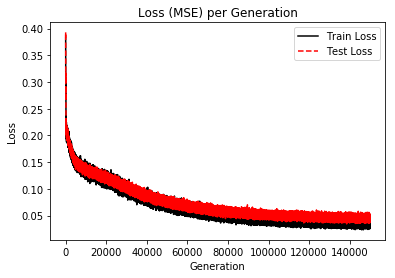

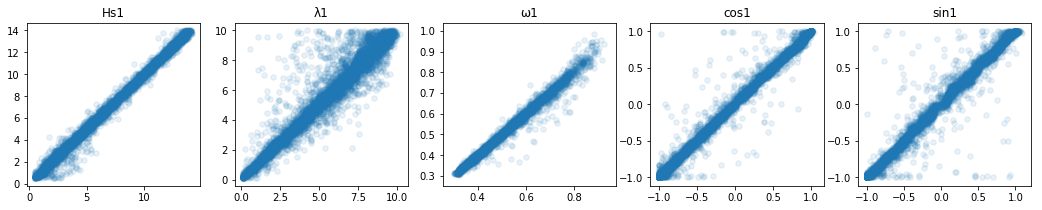

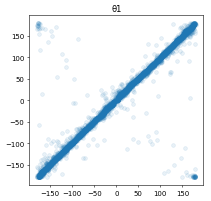

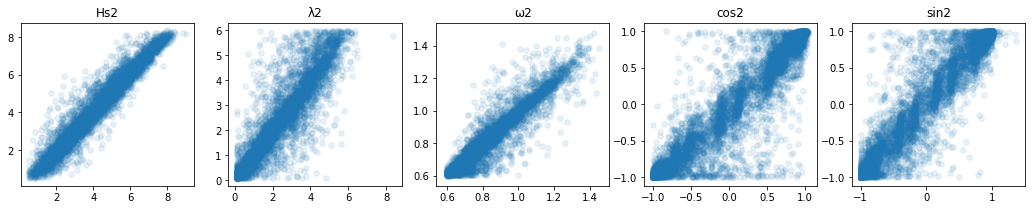

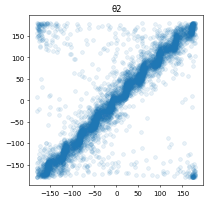

In [19]:
"""描画するグラフの設定"""
siz = 10
#dat = np.zeros((siz, siz))
fig, (axe_H,axe_lambda, axe_w,axe_cos,axe_sin) = plt.subplots(ncols=5, figsize=(15,5))
fig2, (axe_H2,axe_lambda2, axe_w2,axe_cos2,axe_sin2) = plt.subplots(ncols=5, figsize=(15,5))

"""計算始める"""
print("start")
generations         = 50000  #計算回数
eval_every          = 100    #100世代ごとにプロット
for i in range(generations):
    """訓練にデータの作成"""
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]      #入力データの訓練集合からバッチサイズ分取り出す
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_ydata[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss,temp_train_preds = sess.run( [loss,prediction], feed_dict=train_dict)
    
    """テストデータで計算"""
    test_index = np.random.choice(len(test_xdata), size=evaluation_size)
    test_x = test_xdata[test_index]
    test_x = np.expand_dims(test_x, 3)
    test_y = test_ydata[test_index]
    test_dict = {test_x_input: test_x, test_y_target: test_y}
    temp_test_loss= sess.run(test_loss, feed_dict=test_dict)
    

    """訓練データとテストデータそれぞれの誤差を格納"""
    list_train_loss.append(temp_train_loss)
    list_test_loss.append(temp_test_loss)
    
    if (i+1) % eval_every == 0:
        """テストデータで計算"""
        eval_x = test_xdata
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_ydata
        eval_dict = {eval_x_input: eval_x, eval_y_target: eval_y}
        eval_preds = sess.run(eval_prediction, feed_dict=eval_dict)
    
        clear_output(wait = True)
        plt.close()

        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_train_loss)+" ,  Test Loss = "+str(temp_test_loss))
        #グラフをプロット
        plt.plot(list_train_loss, 'k-', label='Train Loss')
        plt.plot(list_test_loss, 'r--', label='Test Loss')
        plt.title('Loss (MSE) per Generation')
        #plt.ylim(0,0.30)
        plt.legend(loc='upper right')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()
        
        axe_H.scatter(eval_preds[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],test_ydata_origin[:,0:1],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H.set_title('Hs1')
        axe_w.scatter(eval_preds[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],test_ydata_origin[:,4:5],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w.set_title('ω1')
        axe_cos.scatter(eval_preds[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],test_ydata_origin[:,1:2],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos.set_title('cos1')
        axe_sin.scatter(eval_preds[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],test_ydata_origin[:,2:3],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin.set_title('sin1')
        axe_lambda.scatter(eval_preds[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],test_ydata_origin[:,3:4],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda.set_title('λ1')
        fig.set_size_inches(18,3)
        display(fig)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H.cla()
        axe_w.cla()
        axe_cos.cla()
        axe_sin.cla()
        axe_lambda.cla()
        
        D_kaku=np.zeros(len(eval_preds[:,4:5]))
        y_val_kaku=np.zeros(len(eval_preds[:,4:5]))
        for i in range(len(eval_preds[:,4:5])):
            D_kaku[i]=math.atan2(eval_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],eval_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
            y_val_kaku[i]=math.atan2(test_ydata_origin[i][2:3],test_ydata_origin[i][1:2])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
        plt.title('θ1')
        plt.show()
        
        
        axe_H2.scatter(eval_preds[:,5:6]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6],test_ydata_origin[:,5:6],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H2.set_title('Hs2')
        axe_w2.scatter(eval_preds[:,9:10]*(col_max0[9:10] - col_min0[9:10]) + col_min0[9:10],test_ydata_origin[:,9:10],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w2.set_title('ω2')
        axe_cos2.scatter(eval_preds[:,6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7],test_ydata_origin[:,6:7],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos2.set_title('cos2')
        axe_sin2.scatter(eval_preds[:,7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],test_ydata_origin[:,7:8],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin2.set_title('sin2')
        axe_lambda2.scatter(eval_preds[:,8:9]*(col_max0[8:9] - col_min0[8:9]) + col_min0[8:9],test_ydata_origin[:,8:9],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda2.set_title('λ2')
        fig2.set_size_inches(18,3)
        display(fig2)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H2.cla()
        axe_w2.cla()
        axe_cos2.cla()
        axe_sin2.cla()
        axe_lambda2.cla()
        
        D_kaku2=np.zeros(len(eval_preds[:,9:10]))
        y_val_kaku2=np.zeros(len(eval_preds[:,9:10]))
        for i in range(len(eval_preds[:,9:10])):
            D_kaku2[i]=math.atan2(eval_preds[i][7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],eval_preds[i][6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7])*180/np.pi
            y_val_kaku2[i]=math.atan2(test_ydata_origin[i][7:8],test_ydata_origin[i][6:7])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku2,y_val_kaku2,s=30, alpha=0.1)
        plt.title('θ2')
        plt.show()

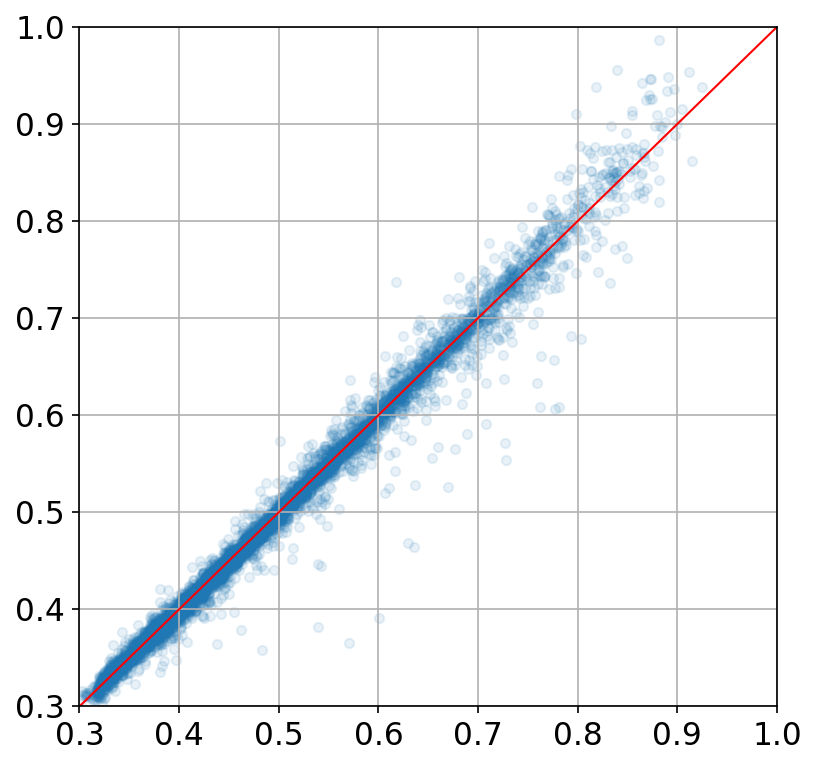

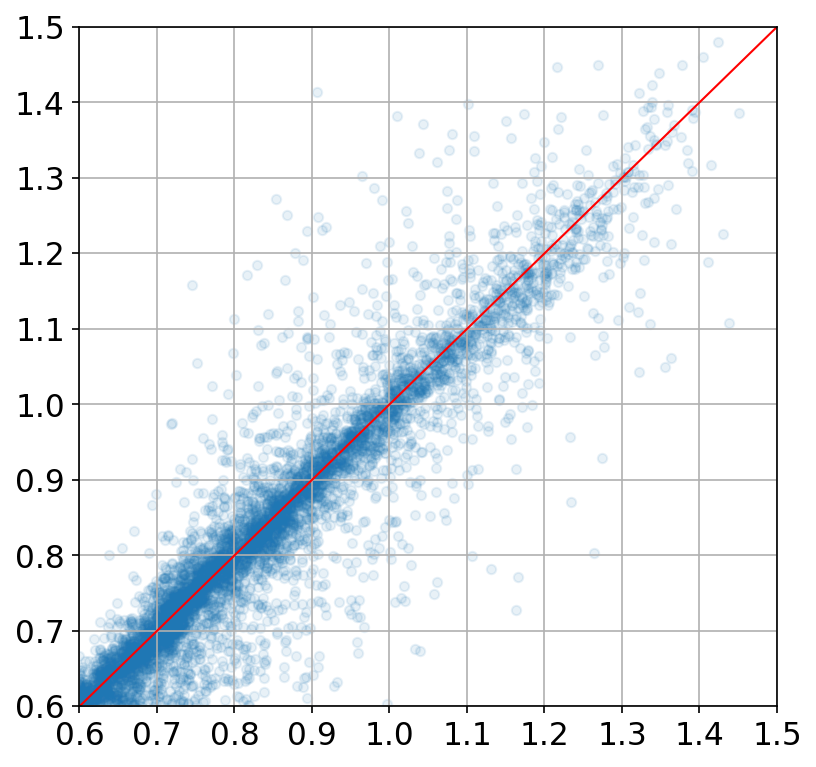

(6000, 10)


In [49]:
column=4
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,column:column+1]*(col_max0[column:column+1] - col_min0[column:column+1]) + col_min0[column:column+1],test_ydata_origin[:,column:column+1],s=20, alpha=0.10)
plt.grid()
plt.xlim(0.3,1)
plt.ylim(0.3,1)
plt.plot([0.3,1],[0.3,1],color='r',linewidth=1)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=9)
plt.locator_params(axis='x',nbins=9)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.show()

column=9
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,column:column+1]*(col_max0[column:column+1] - col_min0[column:column+1]) + col_min0[column:column+1],test_ydata_origin[:,column:column+1],s=20, alpha=0.10)
plt.grid()
plt.xlim(0.6,1.5)
plt.ylim(0.6,1.5)
plt.plot([0.6,1.5],[0.6,1.5],color='r',linewidth=1)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=9)
plt.locator_params(axis='x',nbins=9)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.show()

print(np.shape(eval_preds))

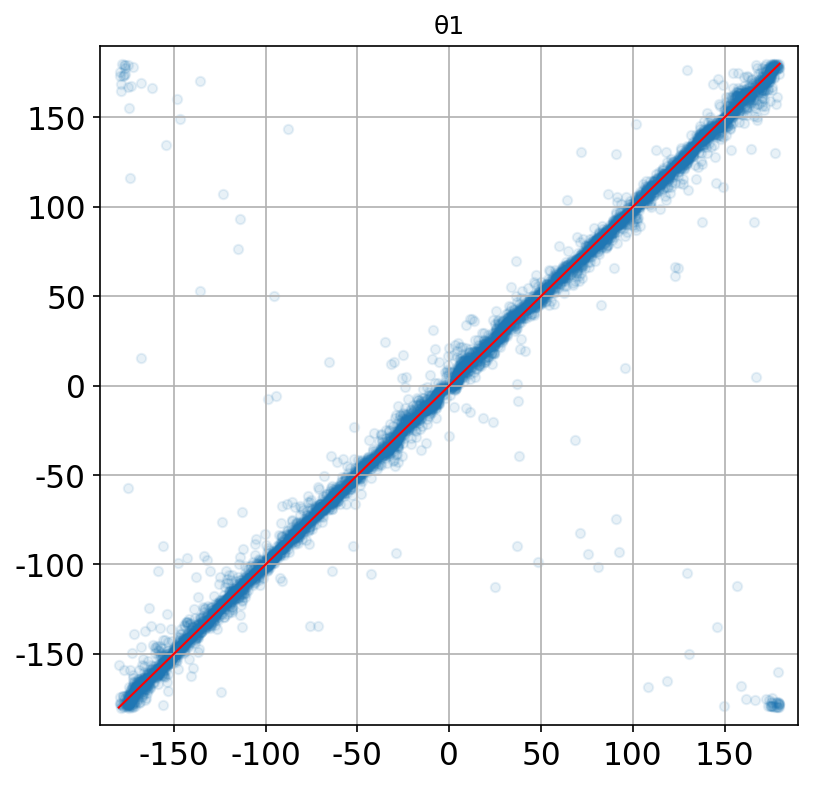

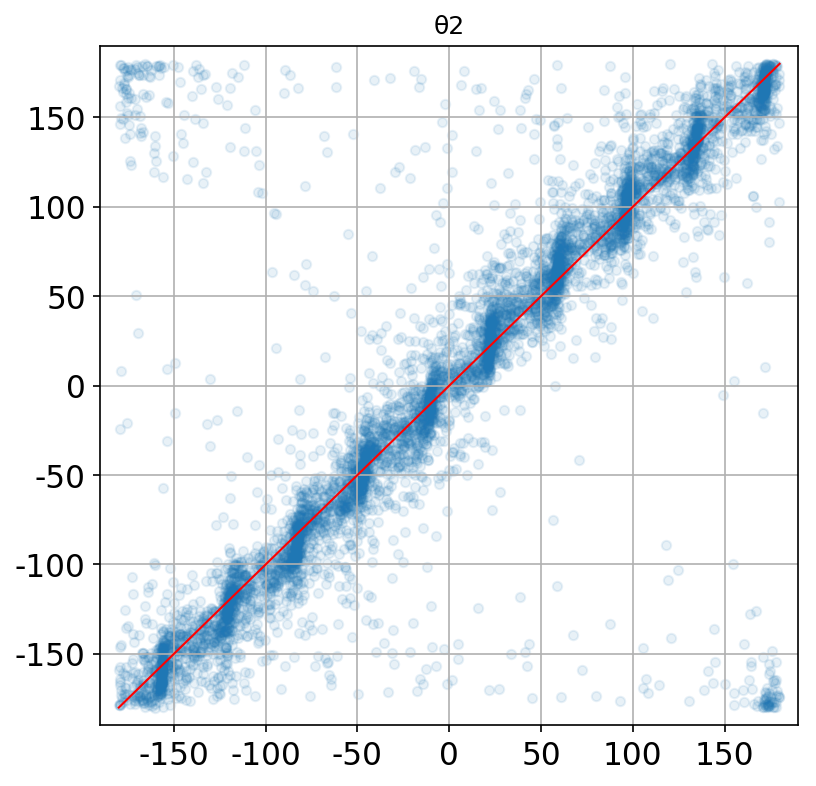

In [51]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(D_kaku,y_val_kaku,s=20, alpha=0.1)
plt.xlim(-190,190)
plt.ylim(-190,190)
plt.plot([-180,180],[-180,180],color='r',linewidth=1)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=9)
plt.locator_params(axis='x',nbins=9)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.title('θ1')
plt.grid()
plt.show()

plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(D_kaku2,y_val_kaku2,s=20, alpha=0.1)
plt.xlim(-190,190)
plt.ylim(-190,190)
plt.plot([-180,180],[-180,180],color='r',linewidth=1)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=9)
plt.locator_params(axis='x',nbins=9)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.title('θ2')
plt.grid()
plt.show()

In [20]:
f=open("estimation_in_testdata_2mine.csv","w",encoding="UTF-8")
f.write("estimation,file =,2mine.csv")
f.write('\n')
for i in range(len(test_indices)):
    for j in range(1146):
        f.write(str(a_df[test_indices[i]][j])+",")
    f.write(str('%03.6f' %(eval_preds[i][0]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]))+","+str('%03.6f' %(eval_preds[i][1]*2-1))+","+str('%03.6f' %(eval_preds[i][2]*2-1))+","+str('%03.6f' %(eval_preds[i][3]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]))+","+str('%03.6f' %(eval_preds[i][4]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]))+",")
    f.write(str('%03.6f' %(eval_preds[i][0+5]*(col_max0[0+5:1+5] - col_min0[0+5:1+5]) + col_min0[0+5:1+5]))+","+str('%03.6f' %(eval_preds[i][1+5]*2-1))+","+str('%03.6f' %(eval_preds[i][2+5]*2-1))+","+str('%03.6f' %(eval_preds[i][3+5]*(col_max0[3+5:4+5] - col_min0[3+5:4+5]) + col_min0[3+5:4+5]))+","+str('%03.6f' %(eval_preds[i][4+5]*(col_max0[4+5:5+5] - col_min0[4+5:5+5]) + col_min0[4+5:5+5])))
    f.write('\n')
f.close()
print("inputも終了")

inputも終了


In [19]:
f=open("LossFunction_2mine.csv","w",encoding="UTF-8")
f.write("train,test")
f.write('\n')
for i in range(len(list_train_loss)):
    f.write(str('%03.6f' %( list_train_loss[i]))+","+str( '%03.6f' %(list_test_loss[i])))
    f.write('\n')
f.close()
print("終了")

終了


# 一峰目の波高推定について調べる

# 1峰海象のデータを入力

In [23]:
"""csvファイルの読み込み"""
optional_input = pd.read_csv('1mine.csv', encoding='shift_jis',dtype = 'float')#ここで任意のファイル名を指定する．
d_df = optional_input.values
#d_df = c_df[40001:80001]
# c_df[np.array(c_df[:,1141:1142]>0.5).flatten()][:]
print(np.shape(d_df))

"""入力データと出力データを分けて読み込む"""
op_xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in d_df])
op_xdata = np.expand_dims(op_xdata, 3)
op_ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in d_df])

"""データの最大値と最小値を保存"""
op_ydata_0 = np.nan_to_num(normalize_cols(op_ydata))

"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
op_input_shape = (len(d_df), image_height, image_width,num_channels)
op_input = tf.placeholder(tf.float32, shape=op_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
op_target = tf.placeholder(tf.float32, shape=(len(d_df),output_shape))


"""畳み込みと全結合層の結果を受け取る"""
op_model_output = my_conv_net(op_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
op_prediction = tf.nn.relu(op_model_output)

"""損失を計算"""
op_loss = tf.reduce_mean(tf.abs(op_prediction - tf.cast(op_target, tf.float32)))


"""計算する"""
op_dict = {op_input: op_xdata ,  op_target: op_ydata_0}
op_loss , op_preds = sess.run( [op_loss , op_prediction], feed_dict=op_dict)

print("平均絶対誤(MAE) ; ="+str(op_loss))
print(np.shape(d_df))
print((d_df[0]))
"""入力データと出力データを分けて読み込む"""
op_xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in d_df])
op_xdata = np.expand_dims(op_xdata, 3)
op_ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in d_df])

"""データの最大値と最小値を保存"""
op_ydata_0 = np.nan_to_num(normalize_cols(op_ydata))

"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
op_input_shape = (len(d_df), image_height, image_width,num_channels)
op_input = tf.placeholder(tf.float32, shape=op_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
op_target = tf.placeholder(tf.float32, shape=(len(d_df),output_shape))


"""畳み込みと全結合層の結果を受け取る"""
op_model_output = my_conv_net(op_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
op_prediction = tf.nn.relu(op_model_output)

"""損失を計算"""
op_loss = tf.reduce_mean(tf.abs(op_prediction - tf.cast(op_target, tf.float32)))


"""計算する"""
op_dict = {op_input: op_xdata ,  op_target: op_ydata_0}
op_loss , op_preds = sess.run( [op_loss , op_prediction], feed_dict=op_dict)

print("平均絶対誤(MAE) ; ="+str(op_loss))

"""f= open("output_only_1mine.csv","w",encoding="UTF-8")
f.write("input,1mine")
f.write('\n')

for i in range(len(op_preds)):
    for j in range(len(op_preds[0])):
        f.write(str(op_preds[i][j]*(col_max0[j] - col_min0[j]) + col_min0[j] )+",")
    f.write('\n')
f.close()
print("end")"""

(40000, 1803)


C:\Users\kouzou\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


平均絶対誤(MAE) ; =0.10473592
(40000, 1803)
[6.00000000e-06 1.10000000e-05 1.10000000e-05 ... 1.97945737e+00
 5.76043000e-01 0.00000000e+00]
平均絶対誤(MAE) ; =0.10473592


'f= open("output_only_1mine.csv","w",encoding="UTF-8")\nf.write("input,1mine")\nf.write(\'\n\')\n\nfor i in range(len(op_preds)):\n    for j in range(len(op_preds[0])):\n        f.write(str(op_preds[i][j]*(col_max0[j] - col_min0[j]) + col_min0[j] )+",")\n    f.write(\'\n\')\nf.close()\nprint("end")'

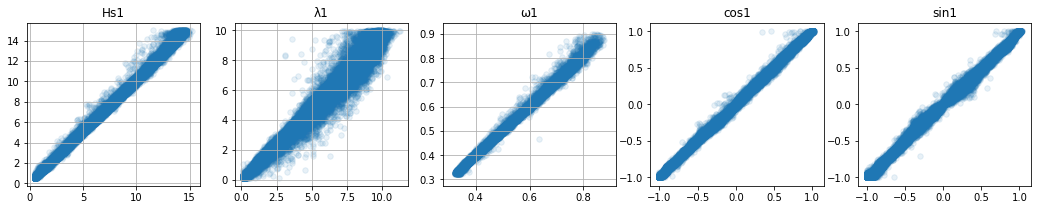

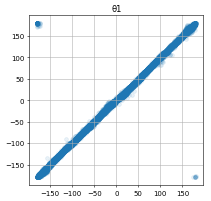

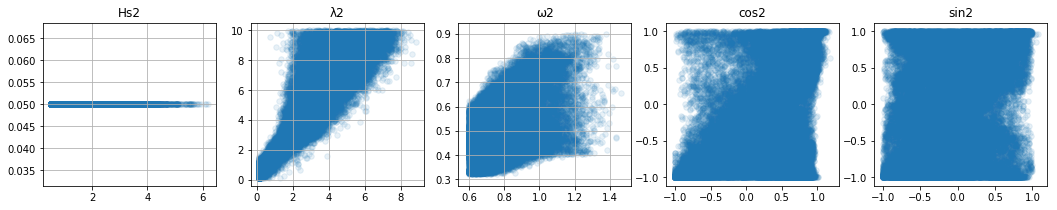

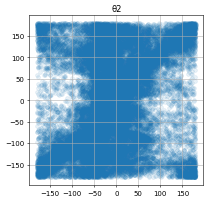

In [24]:
axe_H.scatter(op_preds[:,0:1]*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1],op_ydata[:,0:1],s=30, alpha=0.1)
axe_H.set_title('Hs1')
axe_H.grid()
#axe_H.set_xlim(0,15)
#axe_H.set_ylim(0,15)
axe_w.scatter(op_preds[:,4:5]*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5],op_ydata[:,4:5],s=30, alpha=0.1)
axe_w.grid()
axe_w.set_title('ω1')
axe_cos.scatter(op_preds[:,1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2],op_ydata[:,1:2],s=30, alpha=0.1)
axe_cos.set_title('cos1')
axe_sin.scatter(op_preds[:,2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],op_ydata[:,2:3],s=30, alpha=0.1)
axe_sin.set_title('sin1')
axe_lambda.scatter(op_preds[:,3:4]*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4],op_ydata[:,3:4],s=30, alpha=0.1)
axe_lambda.grid()
axe_lambda.set_title('λ1')
fig.set_size_inches(18,3)
display(fig)
#time.sleep(.2)
#axe_loss.cla()
axe_H.cla()
axe_w.cla()
axe_cos.cla()
axe_sin.cla()
axe_lambda.cla()
        

D_kaku5=np.zeros(len(op_preds[:,4:5]))
y_val_kaku5=np.zeros(len(op_preds[:,4:5]))
for i in range(len(op_preds[:,4:5])):
    D_kaku5[i]=math.atan2(op_preds[i][2:3]*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3],op_preds[i][1:2]*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2])*180/np.pi
    y_val_kaku5[i]=math.atan2(op_ydata[i][2:3],op_ydata[i][1:2])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku5,y_val_kaku5,s=30, alpha=0.1)
plt.title('θ1')
plt.grid()
plt.show()
        
        
axe_H2.scatter(op_preds[:,5:6]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6],op_ydata[:,5:6],s=30, alpha=0.1)
axe_H2.grid()
#axe_H2.set_xlim(0,13)
#axe_H2.set_ylim(0,13)
axe_H2.set_title('Hs2')
axe_w2.scatter(op_preds[:,9:10]*(col_max0[9:10] - col_min0[9:10]) + col_min0[9:10],op_ydata[:,9:10],s=30, alpha=0.1)
axe_w2.grid()
#axe_w2.set_xlim(0.3,1.3)
#axe_w2.set_ylim(0.3,1.3)
axe_w2.set_title('ω2')
axe_cos2.scatter(op_preds[:,6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7],op_ydata[:,6:7],s=30, alpha=0.1)
axe_cos2.set_title('cos2')
axe_sin2.scatter(op_preds[:,7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],op_ydata[:,7:8],s=30, alpha=0.1)
axe_sin2.set_title('sin2')
axe_lambda2.scatter(op_preds[:,8:9]*(col_max0[8:9] - col_min0[8:9]) + col_min0[8:9],op_ydata[:,8:9],s=30, alpha=0.1)
axe_lambda2.grid()
axe_lambda2.set_title('λ2')
fig2.set_size_inches(18,3)
display(fig2)
#time.sleep(.2)
#axe_loss.cla()
axe_H2.cla()
axe_w2.cla()
axe_cos2.cla()
axe_sin2.cla()
axe_lambda2.cla()


D_kaku6=np.zeros(len(op_preds[:,9:10]))
y_val_kaku6=np.zeros(len(op_preds[:,9:10]))
for i in range(len(op_preds[:,9:10])):
    D_kaku6[i]=math.atan2(op_preds[i][7:8]*(col_max0[7:8] - col_min0[7:8]) + col_min0[7:8],op_preds[i][6:7]*(col_max0[6:7] - col_min0[6:7]) + col_min0[6:7])*180/np.pi
    y_val_kaku6[i]=math.atan2(op_ydata[i][7:8],op_ydata[i][6:7])*180/np.pi

plt.figure(figsize=(4.5,4.5),dpi=50)
plt.scatter(D_kaku6,y_val_kaku6,s=30, alpha=0.1)
plt.grid()
plt.title('θ2')
plt.show()

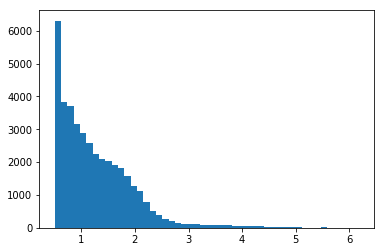

In [28]:
plt.hist(op_preds[:,5:6]*(col_max0[5:6] - col_min0[5:6]) + col_min0[5:6],bins=48)
plt.show()

In [ ]:
#print(np.mean(C[:,3:4]))
theta1_mean=math.atan2(np.mean(D[:,4:5]),np.mean(D[:,3:4]))  #rad
theta2_mean=math.atan2(np.mean(y_vals_test1[:,4:5]),np.mean(y_vals_test1[:,3:4]))

Sxy, Sxx, Syy=0,0,0
for i in range(len(D[:,4:5])-1):
    for j in range(i+1,len(D[:,4:5])):
        Sxy +=math.sin(math.atan2(D[i][4:5],D[i][3:4])-math.atan2(D[j][4:5],D[j][3:4]))*math.sin(math.atan2(y_vals_test1[i][4:5],y_vals_test1[i][3:4])-math.atan2(y_vals_test1[j][4:5],y_vals_test1[j][3:4]))
        Sxx += math.sin(math.atan2(D[i][4:5],D[i][3:4])-math.atan2(D[j][4:5],D[j][3:4]))**2
        Syy += math.sin(math.atan2(y_vals_test1[i][4:5],y_vals_test1[i][3:4])-math.atan2(y_vals_test1[j][4:5],y_vals_test1[j][3:4]))**2
    
Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)

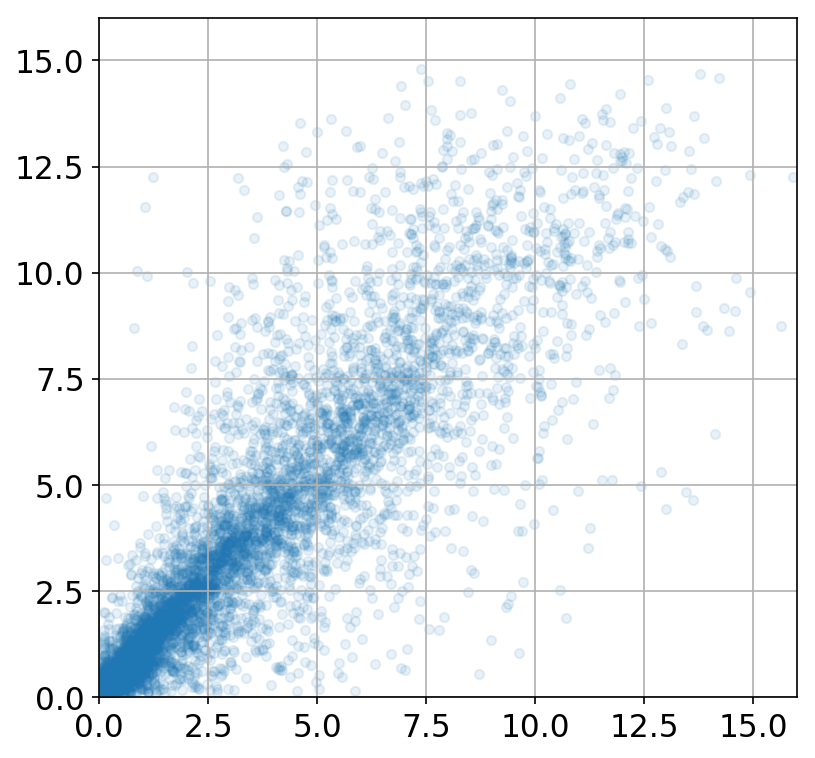

In [25]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,3+5:4+5]*(col_max0[3+5:4+5] - col_min0[3+5:4+5]) + col_min0[3+5:4+5],test_ydata_origin[:,3+5:4+5],s=20, alpha=0.1)
plt.grid()
plt.xlim(0,16)
plt.ylim(0,16)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=7)
plt.locator_params(axis='x',nbins=7)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.show()

In [33]:
print(np.shape(a_df))

(29998, 1147)


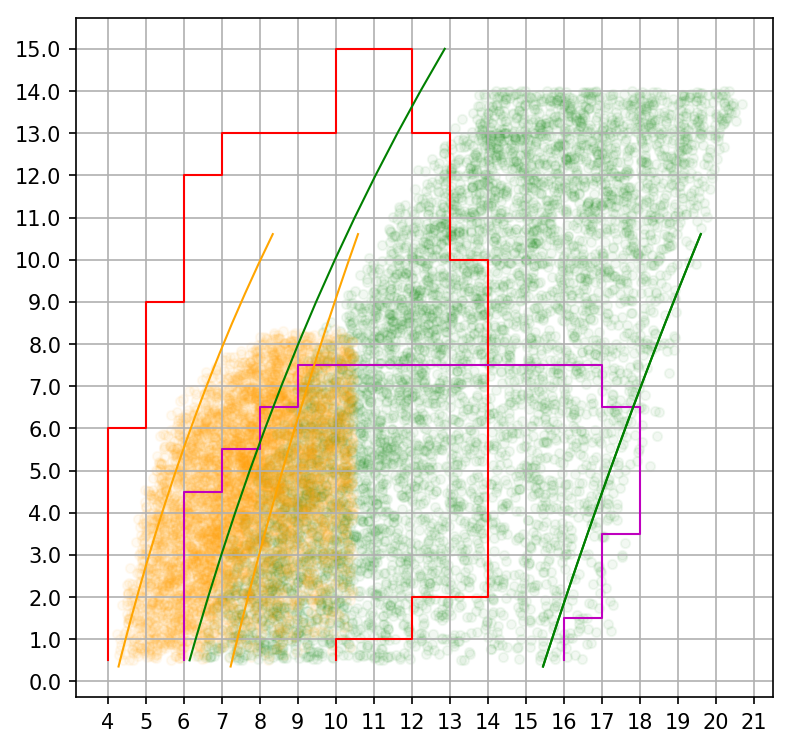

In [21]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(2*np.pi/test_ydata_origin[:,4:5],test_ydata_origin[:,0:1],s=20, alpha=0.05,color='g')
plt.scatter(2*np.pi/test_ydata_origin[:,9:10],test_ydata_origin[:,5:6],s=20, alpha=0.05,color='orange')
plt.grid()
#plt.xlim(0,12)
#plt.ylim(0,12)
plt.plot([4,4,5,5,6,6,7,7,10,10,12,12,13,13,14,14,12,12,10,10],[0.5,6,6,9,9,12,12,13,13,15,15,13,13,10,10,2,2,1,1,0.5],color='r',linewidth=1)
plt.plot([6,6,7,7,8,8,9,9,17,17,18,18,17,17,16,16],[0.5,4.5,4.5,5.5,5.5,6.5,6.5,7.5,7.5,6.5,6.5,3.5,3.5,1.5,1.5,0.5],color='m',linewidth=1)
x11=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
x12=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.plot(2*np.pi/(1.0472*np.exp(-0.0155*x11*3.28084)),x11,color='g',linewidth=1)
plt.plot(2*np.pi/(0.41*np.exp(-0.005*x11*3.28084)),x12/np.sqrt(2),color='g',linewidth=1)
plt.plot(2*np.pi/(0.41*np.exp(-0.005*x11*3.28084)),x12/np.sqrt(2),color='g',linewidth=1)
plt.plot(2*np.pi/(1.50*np.exp(-0.014*x11*3.28084)),x12/np.sqrt(2),color='orange',linewidth=1)
plt.plot(2*np.pi/(0.88*np.exp(-0.008*x11*3.28084)),x12/np.sqrt(2),color='orange',linewidth=1)
plt.tick_params(labelsize=10)
plt.locator_params(axis='y',nbins=26)
plt.locator_params(axis='x',nbins=20)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.show()

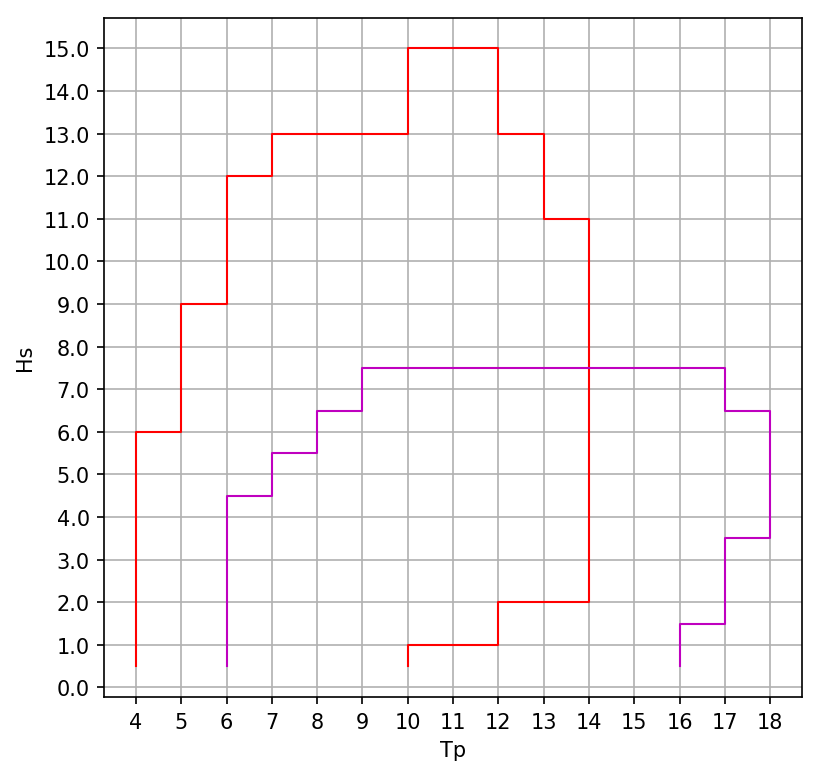

In [24]:
w1=test_ydata_origin[:,4:5]
w2=test_ydata_origin[:,9:10]
H1=test_ydata_origin[:,0:1]
H2=test_ydata_origin[:,5:6]
plt.figure(figsize=(6, 6), dpi=150)
plt.ylabel("Hs")
plt.xlabel("Tp")
#plt.scatter(2*np.pi/test_ydata_origin[:,4:5],np.sqrt(test_ydata_origin[:,0:1]**2+test_ydata_origin[:,5:6]**2),s=20, alpha=0.05,color='g')
#plt.scatter(2*np.pi/test_ydata_origin[:,9:10],np.sqrt(test_ydata_origin[:,0:1]**2+test_ydata_origin[:,5:6]**2),s=20, alpha=0.05,color='orange')
#plt.scatter(2*np.pi/((H1**2*w1+H2**2*w2)/(H1**2+H2**2)),np.sqrt(test_ydata_origin[:,0:1]**2+test_ydata_origin[:,5:6]**2),s=20, alpha=0.05,color='r')
plt.grid()
#plt.xlim(0,12)
#plt.ylim(0,12)
plt.plot([4,4,5,5,6,6,7,7,10,10,12,12,13,13,14,14,12,12,10,10],[0.5,6,6,9,9,12,12,13,13,15,15,13,13,11,11,2,2,1,1,0.5],color='r',linewidth=1)
plt.plot([6,6,7,7,8,8,9,9,17,17,18,18,17,17,16,16],[0.5,4.5,4.5,5.5,5.5,6.5,6.5,7.5,7.5,6.5,6.5,3.5,3.5,1.5,1.5,0.5],color='m',linewidth=1)
x11=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
x12=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#plt.plot(2*np.pi/(0.93*np.exp(-0.017*x11*3.28084)),x11,color='g',linewidth=1)
#plt.plot(2*np.pi/(1.0472*np.exp(-0.017*x11*3.28084)),x11,color='g',linewidth=1)
#plt.plot(2*np.pi/(0.41*np.exp(-0.005*x11*3.28084)),x12,color='g',linewidth=1)
#plt.plot(2*np.pi/(2*np.pi/16*np.exp(-0.005*x11*3.28084)),x12,color='g',linewidth=1)

#plt.plot(2*np.pi/(1.57*np.exp(-0.014*x11*3.28084)),x11,color='orange',linewidth=1)
#plt.plot(2*np.pi/(1.50*np.exp(-0.014*x11*3.28084)),x11/np.sqrt(2),color='orange',linewidth=1)
#plt.plot(2*np.pi/(0.88*np.exp(-0.008*x11*3.28084)),x11,color='orange',linewidth=1)
#plt.plot(2*np.pi/(0.88*np.exp(-0.008*x11*3.28084)),x11/np.sqrt(2),color='orange',linewidth=1)
plt.tick_params(labelsize=10)
plt.locator_params(axis='y',nbins=26)
plt.locator_params(axis='x',nbins=20)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.show()

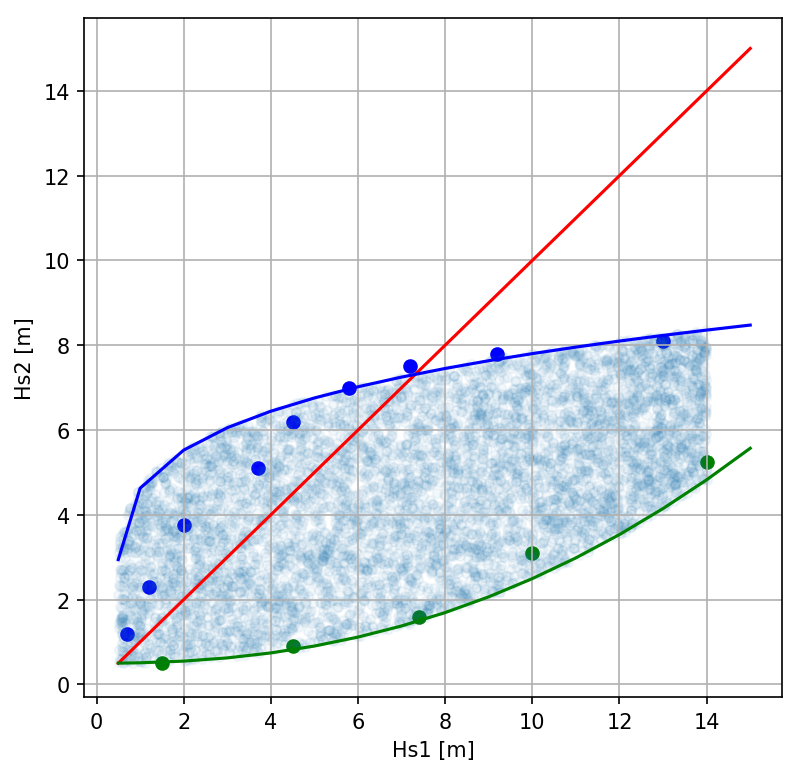

In [30]:
plt.figure(figsize=(6, 6), dpi=150)
x1=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y1=np.array([0.5,1,2,3,4,5,6,7,8,9,10,11])
plt.plot(x1,x1,color='red')
plt.xlabel('Hs1 [m]')
plt.ylabel('Hs2 [m]')
#plt.plot(x1,5+2*np.log(0.5*x1))
plt.plot(x1,5*(0.9*x1**2-0.44*x1)**0.1,color='b')
#plt.plot(x1,5*(x1)**0.24)
plt.plot(x1,0.01*x1**2.3+0.5,color='g')
plt.scatter([0.7,1.2,2,3.7,4.5,5.8,7.2,9.2,13],[1.2,2.3,3.75,5.1,6.2,7,7.5,7.8,8.1],color='b')
plt.scatter([1.5,4.5,7.4,10,14],[0.5,0.9,1.6,3.1,5.25],color='g')
plt.scatter(test_ydata_origin[:,0:1],test_ydata_origin[:,5:6],s=20, alpha=0.05)
plt.grid()
plt.show()

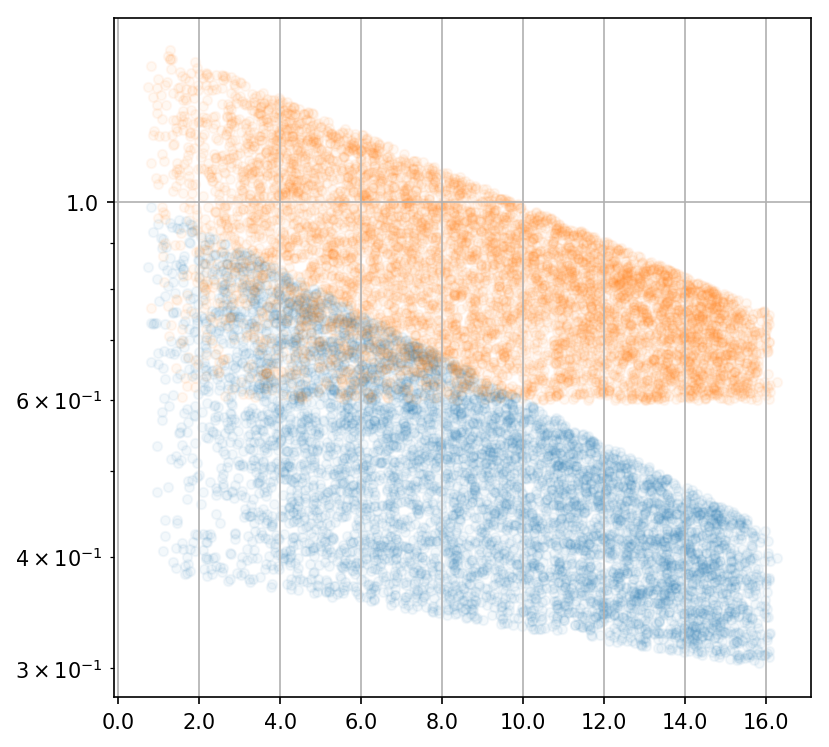

In [35]:
H1=test_ydata_origin[:,0:1]
H2=test_ydata_origin[:,5:6]

plt.figure(figsize=(6, 6), dpi=150)
plt.yscale("log")
plt.scatter(np.sqrt(H1**2+H2**2),test_ydata_origin[:,4:5],s=20, alpha=0.05)
plt.scatter(np.sqrt(H1**2+H2**2),test_ydata_origin[:,9:10],s=20, alpha=0.05)
plt.tick_params(labelsize=10)
#plt.locator_params(axis='y',nbins=5)
#plt.locator_params(axis='x',nbins=5)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.grid()
plt.show()

In [52]:
col_max0

array([13.99988 ,  1.      ,  1.      ,  9.99988 ,  0.998547,  8.353662,
        1.      ,  1.      ,  5.999312,  1.501325])

In [53]:
col_min0

array([ 0.500087, -1.      , -1.      ,  0.100605,  0.30259 ,  0.510879,
       -1.      , -1.      ,  0.100035,  0.600018])